In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import random

import pandas as pd
import numpy as np
import torch

sys.path.append(os.path.abspath('..'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 123456

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
sequence_length = 24
batch_size = 32

In [3]:
from crypto_price_analysis import BinanceDataset

binance_dataset = BinanceDataset(Path("../data"), "ETHUSDT", "15m", sequence_length + 1)

binance_dataset.download_binance_dataset()
data_chunks, mean, std = binance_dataset.preprocess_binance_dataset()

Failed to dowload https://data.binance.vision/data/spot/monthly/klines/ETHUSDT/15m/ETHUSDT-15m-2024-07.zip


In [4]:
from crypto_price_analysis.dataset import ChunkedSequenceDataset
from torch.utils.data import DataLoader, SubsetRandomSampler

def dataframe_to_tensor(dataframe: pd.DataFrame | pd.Series, torch_device=device):
    return torch.Tensor(dataframe.values.astype(np.float32)).to(torch_device)

dataset = ChunkedSequenceDataset(list(map(dataframe_to_tensor, data_chunks)), sequence_length)

In [5]:
dataset_size = len(dataset)
testset_size = 4 * 24 * 7

testset_X, testset_y = zip(*[dataset[i] for i in range(dataset_size - testset_size, dataset_size)])
testset_X = torch.stack(testset_X)
testset_y = torch.stack(testset_y)

valset_size = int(0.05 * (dataset_size - testset_size))
trainset_size = dataset_size - testset_size - valset_size

indices = np.arange(dataset_size - testset_size, dtype=int)
np.random.shuffle(indices)

val_indices, train_indices = indices[:valset_size], indices[valset_size:]

val_sampler = SubsetRandomSampler(val_indices.tolist())
train_sampler = SubsetRandomSampler(train_indices.tolist())

val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

print(trainset_size, valset_size, testset_size)

231126 12164 672


In [6]:
import torch.nn as nn

class ReturnsForecast(nn.Module):

    def __init__(self, hidden_size, ff_hidden_size, num_layers, dropout = 0.):
        super(ReturnsForecast, self).__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

        self.linear1 = nn.Linear(hidden_size, ff_hidden_size)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(ff_hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear1(x[:,-1,:])
        x = self.tanh(x)
        return self.linear2(x)
    

In [7]:
retrain_model = True

In [11]:
from crypto_price_analysis.train import train_model

model = ReturnsForecast(hidden_size=64, ff_hidden_size=8, num_layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
loss_function = nn.MSELoss()

model_path = '../model/lstm-model.h5'
if retrain_model or not Path(model_path).exists():
    train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, loss_function, 300, scheduler)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))

epoch:    0 duration: 31.62s loss: 1.00509 val_loss: 0.94499
epoch:    1 duration: 35.11s loss: 1.00513 val_loss: 0.94331
epoch:    2 duration: 35.20s loss: 1.00595 val_loss: 0.94329
epoch:    3 duration: 33.46s loss: 1.00512 val_loss: 0.94384
epoch:    4 duration: 32.89s loss: 1.00541 val_loss: 0.94369
epoch:    5 duration: 33.96s loss: 1.00525 val_loss: 0.94257
epoch:    6 duration: 33.07s loss: 1.00435 val_loss: 0.94182
epoch:    7 duration: 33.62s loss: 1.00404 val_loss: 0.94455
epoch:    8 duration: 33.75s loss: 1.00329 val_loss: 0.92867
epoch:    9 duration: 34.89s loss: 1.00287 val_loss: 0.94050
epoch:   10 duration: 32.96s loss: 1.00018 val_loss: 0.94021
epoch:   11 duration: 33.20s loss: 1.00288 val_loss: 0.93420
epoch:   12 duration: 33.39s loss: 1.00432 val_loss: 0.93846
epoch:   13 duration: 31.46s loss: 1.00207 val_loss: 0.95014
epoch:   14 duration: 35.50s loss: 1.00062 val_loss: 0.93752
epoch:   15 duration: 34.95s loss: 0.99927 val_loss: 0.93515
epoch:   16 duration: 34

In [19]:
import typing
import collections.abc

model.eval()
counts = np.array([0, 0])
running_loss = 0

with torch.no_grad():
    for x, y in train_loader:
        y_pred = model(x)

        y_pred_untransformed = torch.expm1(y_pred * std.iloc[3] + mean.iloc[3])
        y_untransformed = torch.expm1(y * std.iloc[3] + mean.iloc[3])

        running_loss += nn.functional.l1_loss(y_pred_untransformed, y_untransformed) * x.size(0)

        score = np.where((y_pred_untransformed * y_untransformed).cpu() > 0, 1, 0)
        unique, count = np.unique(score, return_counts=True)
        counts[unique] += count

print(f'accuracy: {counts[1] / (counts[0] + counts[1])} mae: {running_loss / len(typing.cast(collections.abc.Sized, train_loader.sampler))}') 
print(counts)

accuracy: 0.5007794097270334 mae: 0.0029464084655046463
[115292 115652]


In [26]:
model.eval()
with torch.no_grad():
    y_pred = model(testset_X)

    y_pred_untransformed = torch.expm1(y_pred * std.iloc[3] + mean.iloc[3])
    y_untransformed = torch.expm1(testset_y * std.iloc[3] + mean.iloc[3])

    loss = nn.functional.l1_loss(y_pred_untransformed, y_untransformed)

score = np.where((y_pred_untransformed * y_untransformed).cpu() > 0, 1, 0)
unique, counts = np.unique(score, return_counts=True)

print(f'accuracy: {counts[1] / (counts[0] + counts[1])} mae: {loss}') 
print(counts)

accuracy: 0.5059523809523809 mae: 0.002245479030534625
[332 340]


## Backtesting

In [27]:
backtest = data_chunks[-1][['close']][-testset_size:] 
backtest['close'] = np.expm1(backtest['close'] * std.iloc[3] + mean.iloc[3])
backtest

,close
open_time,
2024-07-28 00:00:00,-0.004875
2024-07-28 00:15:00,0.003207
2024-07-28 00:30:00,0.001064
2024-07-28 00:45:00,-0.000059
2024-07-28 01:00:00,0.001235
...,...
2024-08-03 22:45:00,0.000334
2024-08-03 23:00:00,-0.002530
2024-08-03 23:15:00,0.003701


In [28]:
with torch.no_grad():
    backtest['pred'] = model(testset_X).cpu()
backtest['pred'] = np.expm1(backtest['pred'] * std.iloc[3] + mean.iloc[3])

In [29]:
backtest

,close,pred
open_time,,
2024-07-28 00:00:00,-0.004875,-0.000005
2024-07-28 00:15:00,0.003207,-0.000003
2024-07-28 00:30:00,0.001064,0.000006
2024-07-28 00:45:00,-0.000059,-0.000041
2024-07-28 01:00:00,0.001235,-0.000025
...,...,...
2024-08-03 22:45:00,0.000334,-0.000006
2024-08-03 23:00:00,-0.002530,-0.000016
2024-08-03 23:15:00,0.003701,-0.000004


In [30]:
backtest['pred_sign'] = np.sign(backtest['pred'])
backtest['returns'] = backtest['pred_sign'] * backtest['close']

1.0310506785691138

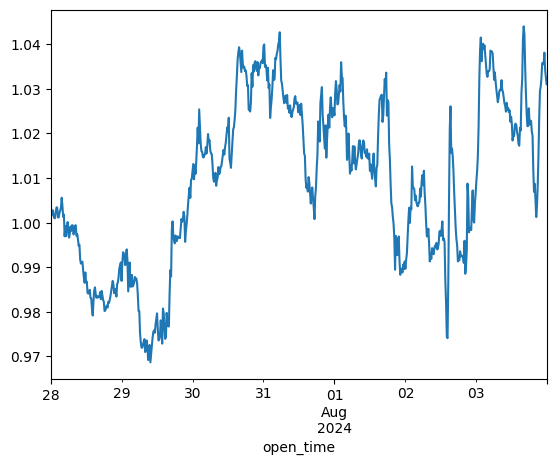

In [32]:
(backtest['returns'] + 1).cumprod().plot()
(backtest['returns'] + 1).prod()

0.8936999270546983

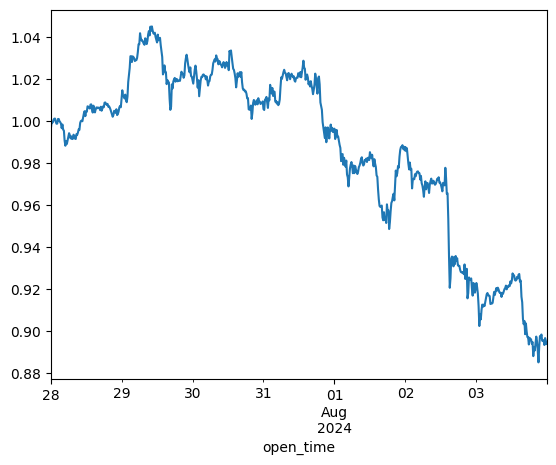

In [33]:
(backtest['close'] + 1).cumprod().plot()
(backtest['close'] + 1).prod()